<a href="https://colab.research.google.com/github/usermar445/aml_final_project/blob/main/scripts/aml_pipeline_heloc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Load data

In [69]:
#df_tree = pd.read_csv("/content/drive/MyDrive/aml/data/covtype_train.csv")
#df_higgs = pd.read_csv("/content/drive/MyDrive/aml/data/higgs_train.csv")
df_heloc = pd.read_csv("/content/drive/MyDrive/aml/data/heloc_train.csv")

In [70]:
df_heloc.values.shape

(9413, 24)

In [71]:
df_heloc

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,69,148,4,66,41,0,0,100,-7,...,10,-7,1,1,32,60,7,3,1,50
1,Bad,77,229,3,109,23,0,0,100,-7,...,35,0,0,0,38,93,4,3,1,58
2,Bad,58,46,7,38,13,0,0,93,8,...,50,-7,2,2,80,84,5,4,1,90
3,Bad,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
4,Bad,80,226,2,66,35,0,0,100,-7,...,47,0,0,0,2,77,5,7,0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9408,Bad,65,115,11,43,19,0,0,90,1,...,50,-7,0,0,52,77,5,6,0,85
9409,Bad,77,437,8,115,35,0,0,100,-7,...,26,1,3,3,23,74,6,2,0,50
9410,Good,75,140,7,56,21,0,0,100,-7,...,27,0,1,1,20,63,3,2,1,56
9411,Bad,64,92,3,35,21,2,2,91,33,...,23,0,1,1,9,58,3,4,0,53


In [72]:
heloc = df_heloc.drop('RiskPerformance', axis=1)

In [73]:
#replace na values
heloc[heloc<0] = np.nan

**Check NaN rows**


In [74]:
def get_indexes_nan_rows(data):
  all_na = data.isna().all(axis=1)
  all_na = all_na[all_na==True]
  return all_na.index

In [75]:
na_indexes = get_indexes_nan_rows(heloc)

In [76]:
df_heloc['RiskPerformance'] = df_heloc['RiskPerformance'].replace(('Bad','Good'), (0,1))

In [80]:
def get_distribution_of_na_rows(data, na_index):
  agg = data.loc[na_index, :].groupby('RiskPerformance').size()
  return agg[1]/(agg[0]+agg[1])

In [38]:
p = get_distribution_of_na_rows(df_heloc, na_indexes)

**Check missing values**


In [42]:
def get_missing_values_per_columns(data, columns, threshold):
  missing = {}
  problematic = []
  for column in columns:
    col = data.loc[:, column]
    nans = np.isnan(col)
    nans = nans[nans == True]
    missing_values = len(nans)/len(col)
    missing.update({column: missing_values})
    if missing_values >= threshold:
      problematic.append(column)
  return [missing, problematic]

nas = get_missing_values_per_columns(heloc, heloc.columns.to_list(), 0.15)

In [43]:
nas[0]

{'ExternalRiskEstimate': 0.05811112291511739,
 'MSinceOldestTradeOpen': 0.08031445872729204,
 'MSinceMostRecentTradeOpen': 0.05704876234994157,
 'AverageMInFile': 0.05704876234994157,
 'NumSatisfactoryTrades': 0.05704876234994157,
 'NumTrades60Ever2DerogPubRec': 0.05704876234994157,
 'NumTrades90Ever2DerogPubRec': 0.05704876234994157,
 'PercentTradesNeverDelq': 0.05704876234994157,
 'MSinceMostRecentDelq': 0.519813024540529,
 'MaxDelq2PublicRecLast12M': 0.05704876234994157,
 'MaxDelqEver': 0.05704876234994157,
 'NumTotalTrades': 0.05704876234994157,
 'NumTradesOpeninLast12M': 0.05704876234994157,
 'PercentInstallTrades': 0.05704876234994157,
 'MSinceMostRecentInqexcl7days': 0.2823754382237331,
 'NumInqLast6M': 0.05704876234994157,
 'NumInqLast6Mexcl7days': 0.05704876234994157,
 'NetFractionRevolvingBurden': 0.07542760012748327,
 'NetFractionInstallBurden': 0.3848932327631998,
 'NumRevolvingTradesWBalance': 0.07255922660150856,
 'NumInstallTradesWBalance': 0.14055030277276107,
 'NumBank

In [44]:
missing_value_columns = nas[1]
missing_value_columns

['MSinceMostRecentDelq',
 'MSinceMostRecentInqexcl7days',
 'NetFractionInstallBurden']

In [45]:
heloc = heloc.drop(missing_value_columns, axis=1)

In [46]:
heloc.values.shape

(9413, 20)

**Create proper Nans and impute values**



In [47]:
#because most of the features are very skewed, median seems more reasonable
def impute_heloc(data):
  imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
  columns = data.columns
  indexes = data.index
  imp_median.fit(data.values)
  data = imp_median.transform(data.values)
  data = pd.DataFrame(data, columns=columns)
  data = data.set_index(indexes)
  return data

In [48]:
heloc = impute_heloc(heloc)

In [49]:
heloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9413 entries, 0 to 9412
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ExternalRiskEstimate                9413 non-null   float64
 1   MSinceOldestTradeOpen               9413 non-null   float64
 2   MSinceMostRecentTradeOpen           9413 non-null   float64
 3   AverageMInFile                      9413 non-null   float64
 4   NumSatisfactoryTrades               9413 non-null   float64
 5   NumTrades60Ever2DerogPubRec         9413 non-null   float64
 6   NumTrades90Ever2DerogPubRec         9413 non-null   float64
 7   PercentTradesNeverDelq              9413 non-null   float64
 8   MaxDelq2PublicRecLast12M            9413 non-null   float64
 9   MaxDelqEver                         9413 non-null   float64
 10  NumTotalTrades                      9413 non-null   float64
 11  NumTradesOpeninLast12M              9413 no

**Check pseudo categorical**

In [50]:
heloc.nunique()

ExternalRiskEstimate                   60
MSinceOldestTradeOpen                 522
MSinceMostRecentTradeOpen             110
AverageMInFile                        233
NumSatisfactoryTrades                  73
NumTrades60Ever2DerogPubRec            18
NumTrades90Ever2DerogPubRec            16
PercentTradesNeverDelq                 71
MaxDelq2PublicRecLast12M                9
MaxDelqEver                             7
NumTotalTrades                         85
NumTradesOpeninLast12M                 18
PercentInstallTrades                   94
NumInqLast6M                           26
NumInqLast6Mexcl7days                  26
NetFractionRevolvingBurden            126
NumRevolvingTradesWBalance             28
NumInstallTradesWBalance               18
NumBank2NatlTradesWHighUtilization     17
PercentTradesWBalance                  93
dtype: int64

In [51]:
df_heloc.groupby(['MaxDelqEver', 'RiskPerformance']).size()

MaxDelqEver  RiskPerformance
-9           Bad                 296
             Good                241
 2           Bad                 464
             Good                200
 3           Bad                 179
             Good                102
 4           Bad                 197
             Good                 96
 5           Bad                 570
             Good                301
 6           Bad                1534
             Good               1034
 7           Bad                  50
             Good                 70
 8           Bad                1635
             Good               2444
dtype: int64

In [52]:
df_heloc.groupby(['MaxDelq2PublicRecLast12M', 'RiskPerformance']).size()

MaxDelq2PublicRecLast12M  RiskPerformance
-9                        Bad                 296
                          Good                241
 0                        Bad                 223
                          Good                 80
 1                        Bad                  28
                          Good                 16
 2                        Bad                  35
                          Good                 15
 3                        Bad                 142
                          Good                 60
 4                        Bad                1045
                          Good                386
 5                        Bad                 151
                          Good                 61
 6                        Bad                1545
                          Good               1296
 7                        Bad                1456
                          Good               2332
 9                        Bad                   4
        

Looks okish



**Check skewedness and transform**

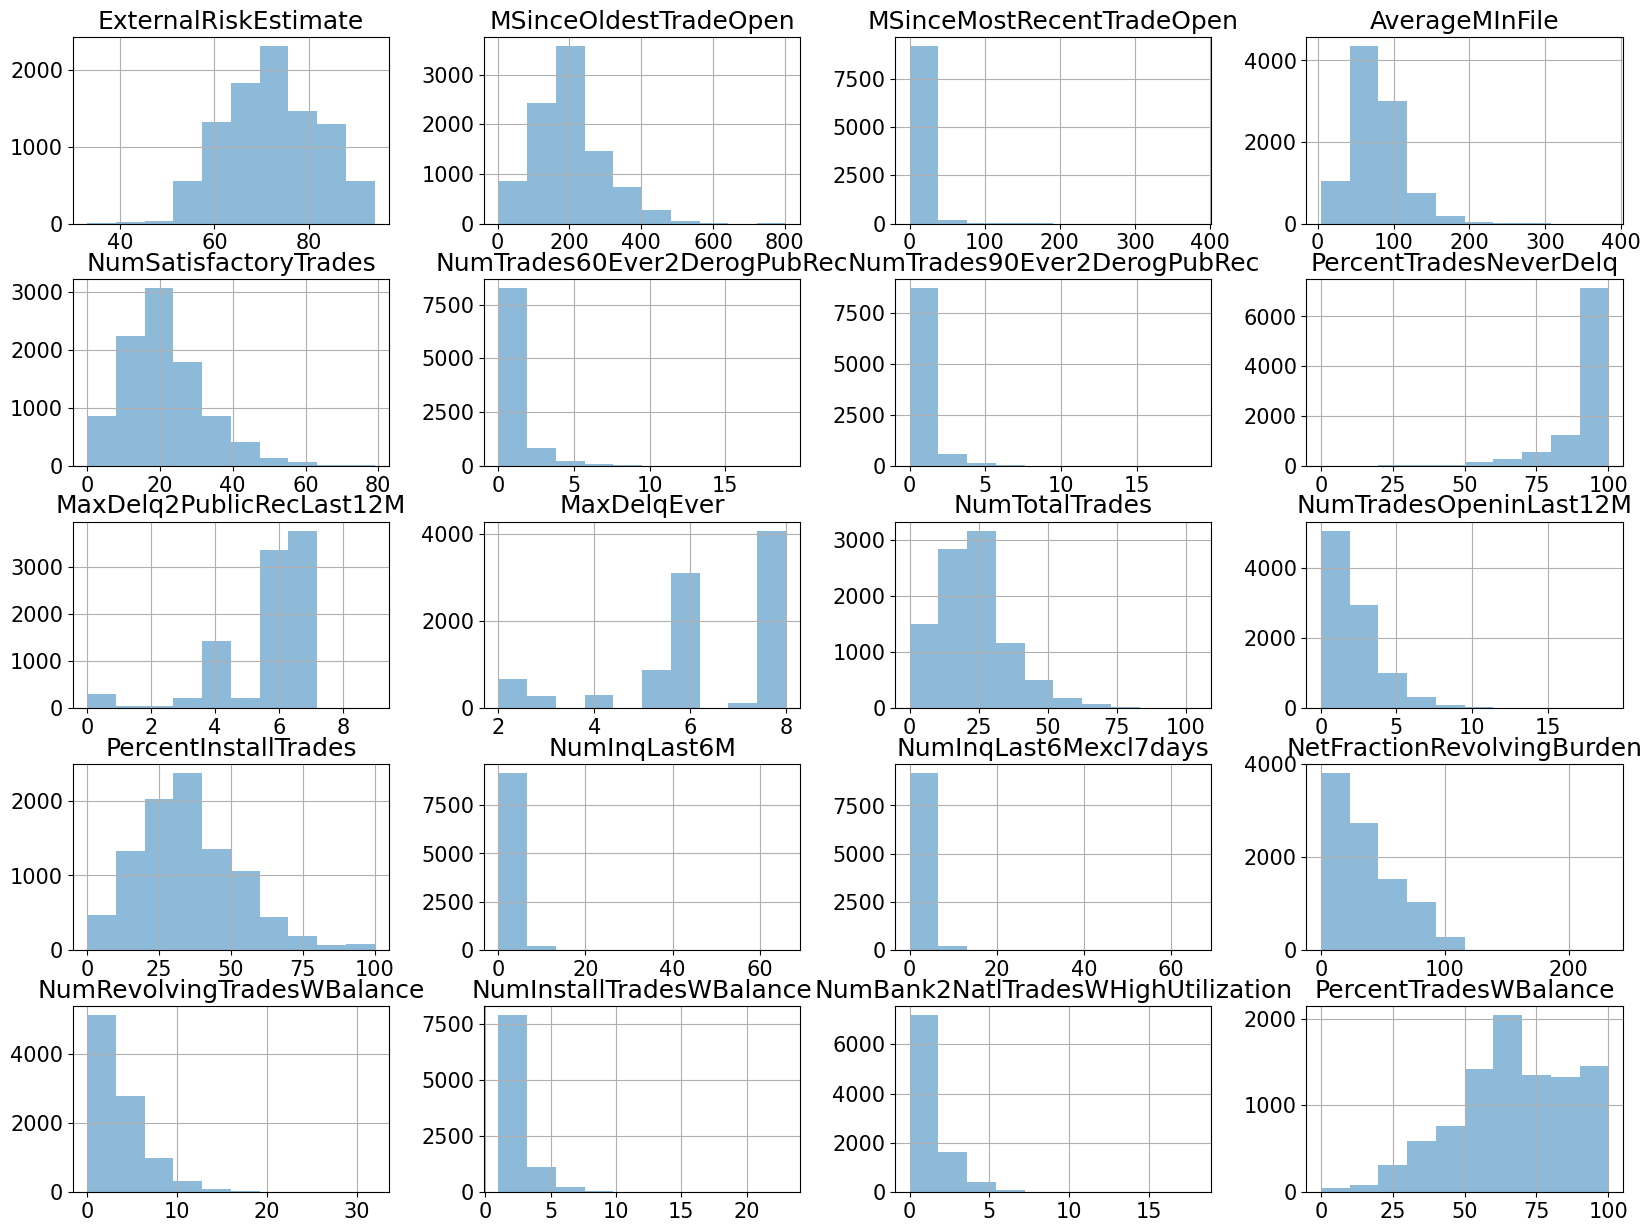

In [53]:
plt.rcParams['font.size'] = 15
heloc.hist(alpha=0.5, figsize=(20, 15))
plt.show()

In [59]:
def transform_heloc(data):
  pt = PowerTransformer(method='box-cox', standardize=False)
  arr = data[0].values
  arr = arr+1
  pt.fit(arr)
  transformed = pt.transform(arr)
  if len(data)>1:
      arr2 = data[1].values
      arr2 = arr2+1
      transformed2 = pt.transform(arr2)
      transformed2 = pd.DataFrame(transformed2, columns=data[0].columns)
  transformed = pd.DataFrame(transformed, columns=data[0].columns)
  return [transformed, transformed]

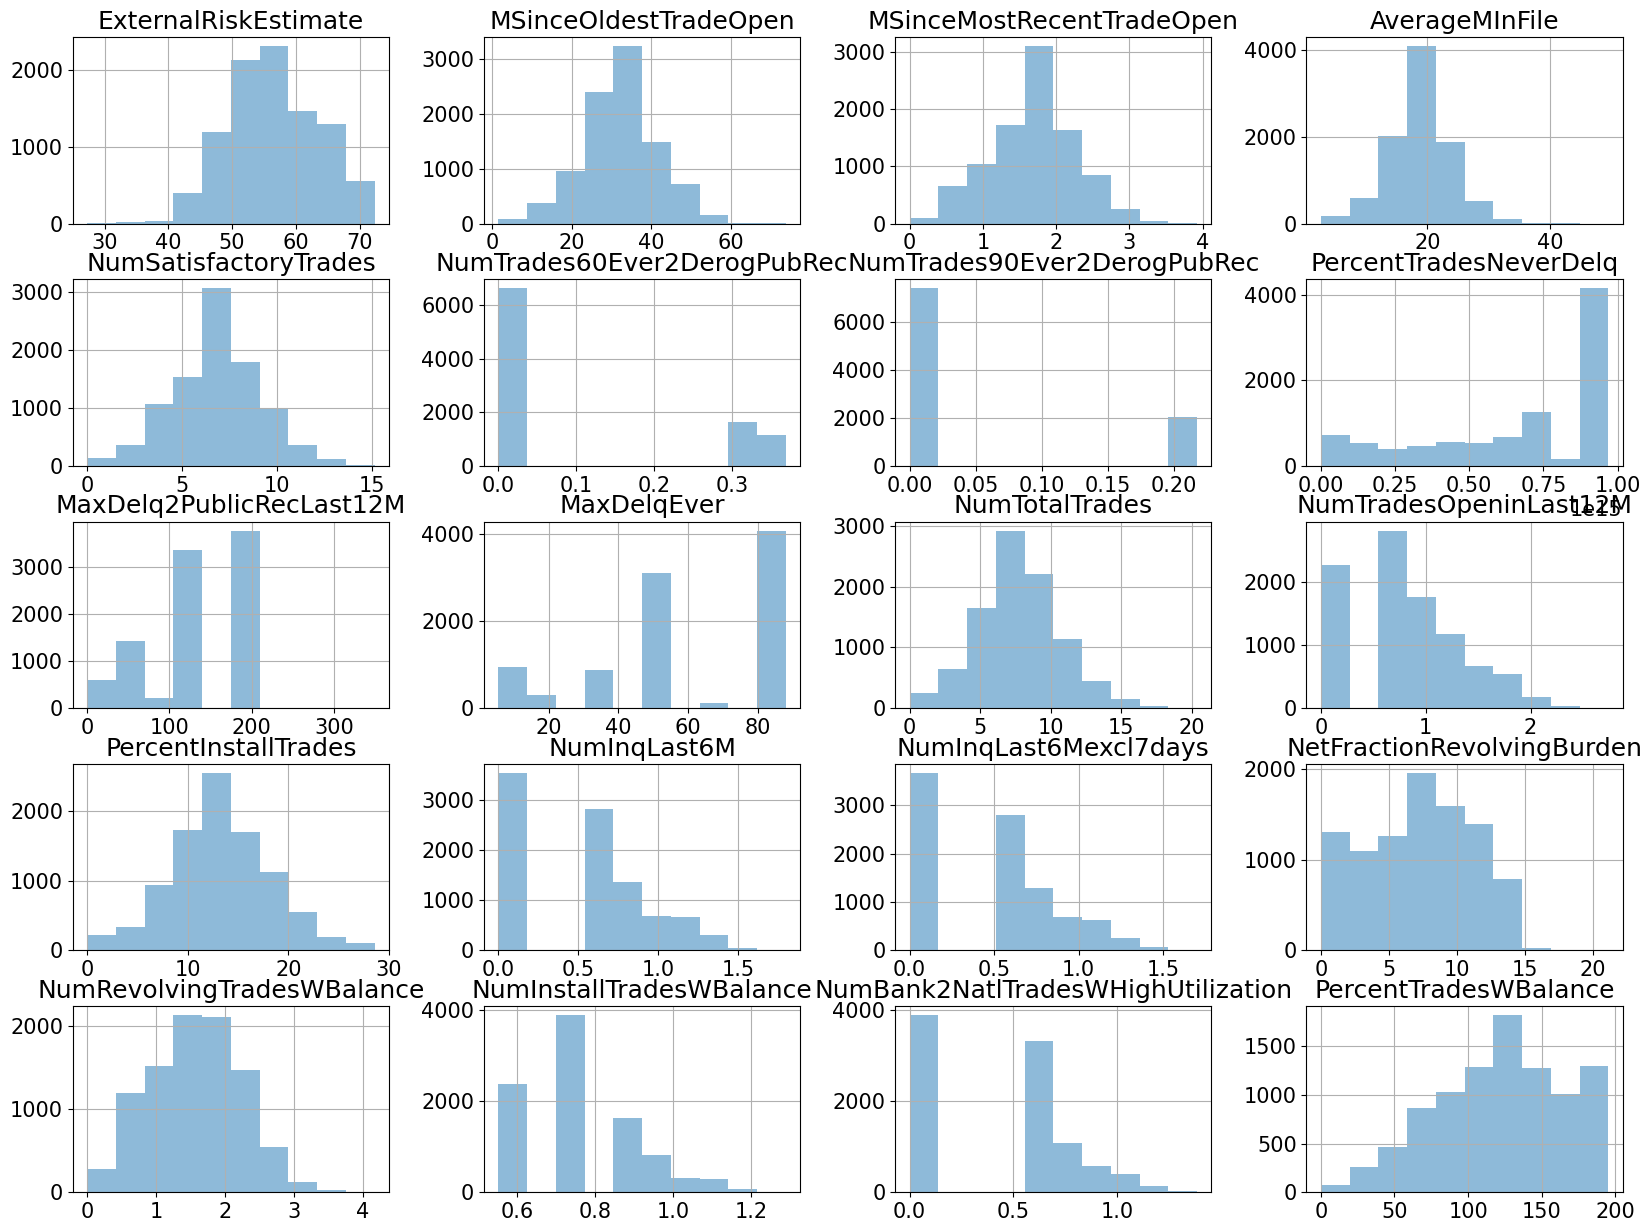

In [60]:
transformed = transform_heloc([heloc])
plt.rcParams['font.size'] = 15
transformed[0].hist(alpha=0.5, figsize=(20, 15))
plt.show()

**Check balancedness of features**

In [61]:
def test_balancedness(data, columns):
  for column in columns:
    selection = data[[column, 'RiskPerformance']].copy()
    print(column)
    print(selection[selection[column] >= selection[column].mean()].groupby('RiskPerformance').size())

transformed = transformed[0].join(df_heloc[['RiskPerformance']])

test_balancedness(transformed, heloc.columns.to_list())

ExternalRiskEstimate
RiskPerformance
Bad     1280
Good    2917
dtype: int64
MSinceOldestTradeOpen
RiskPerformance
Bad     1811
Good    2375
dtype: int64
MSinceMostRecentTradeOpen
RiskPerformance
Bad     2667
Good    2559
dtype: int64
AverageMInFile
RiskPerformance
Bad     2148
Good    2875
dtype: int64
NumSatisfactoryTrades
RiskPerformance
Bad     2360
Good    2649
dtype: int64
NumTrades60Ever2DerogPubRec
RiskPerformance
Bad     1868
Good     918
dtype: int64
NumTrades90Ever2DerogPubRec
RiskPerformance
Bad     1379
Good     650
dtype: int64
PercentTradesNeverDelq
RiskPerformance
Bad     2339
Good    3222
dtype: int64
MaxDelq2PublicRecLast12M
RiskPerformance
Bad     1460
Good    2333
dtype: int64
MaxDelqEver
RiskPerformance
Bad     1685
Good    2514
dtype: int64
NumTotalTrades
RiskPerformance
Bad     2465
Good    2615
dtype: int64
NumTradesOpeninLast12M
RiskPerformance
Bad     2398
Good    1941
dtype: int64
PercentInstallTrades
RiskPerformance
Bad     2874
Good    2188
dtype: int64
NumI

Looks ok

In [62]:
transformed.values.shape

(9413, 21)

**Check multicollinearity**

In [315]:
transformed = transformed.drop('RiskPerformance', axis=1)

<ipython-input-316-90fae4472eb1>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

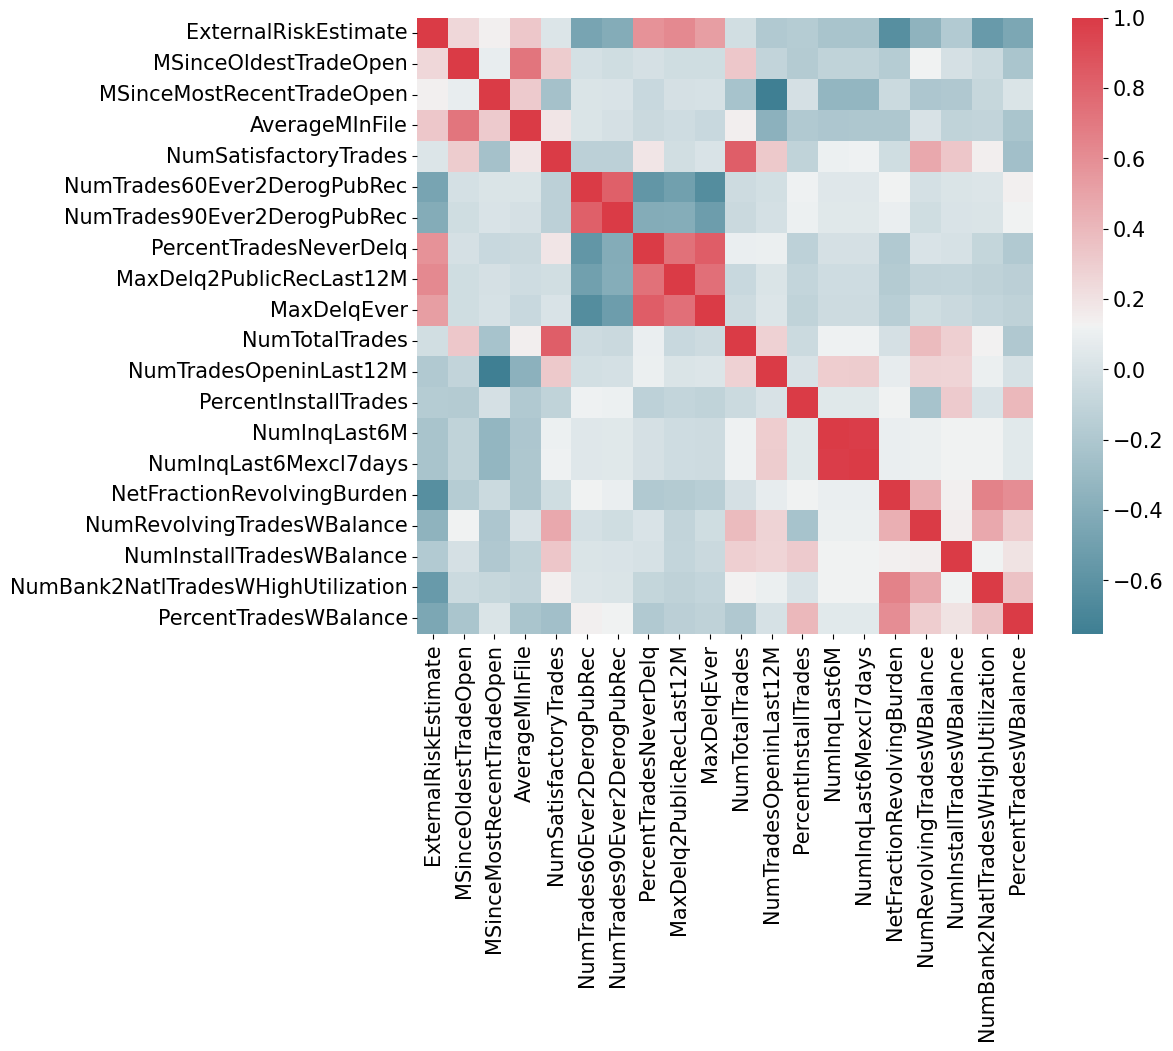

In [316]:
f, ax = plt.subplots(figsize=(10, 8))
corr = transformed.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [317]:
collinearity = ['NumTotalTrades', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumInqLast6Mexcl7days', 'NumTrades90Ever2DerogPubRec']

In [318]:
transformed = transformed.drop(collinearity, axis=1)

<ipython-input-319-90fae4472eb1>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

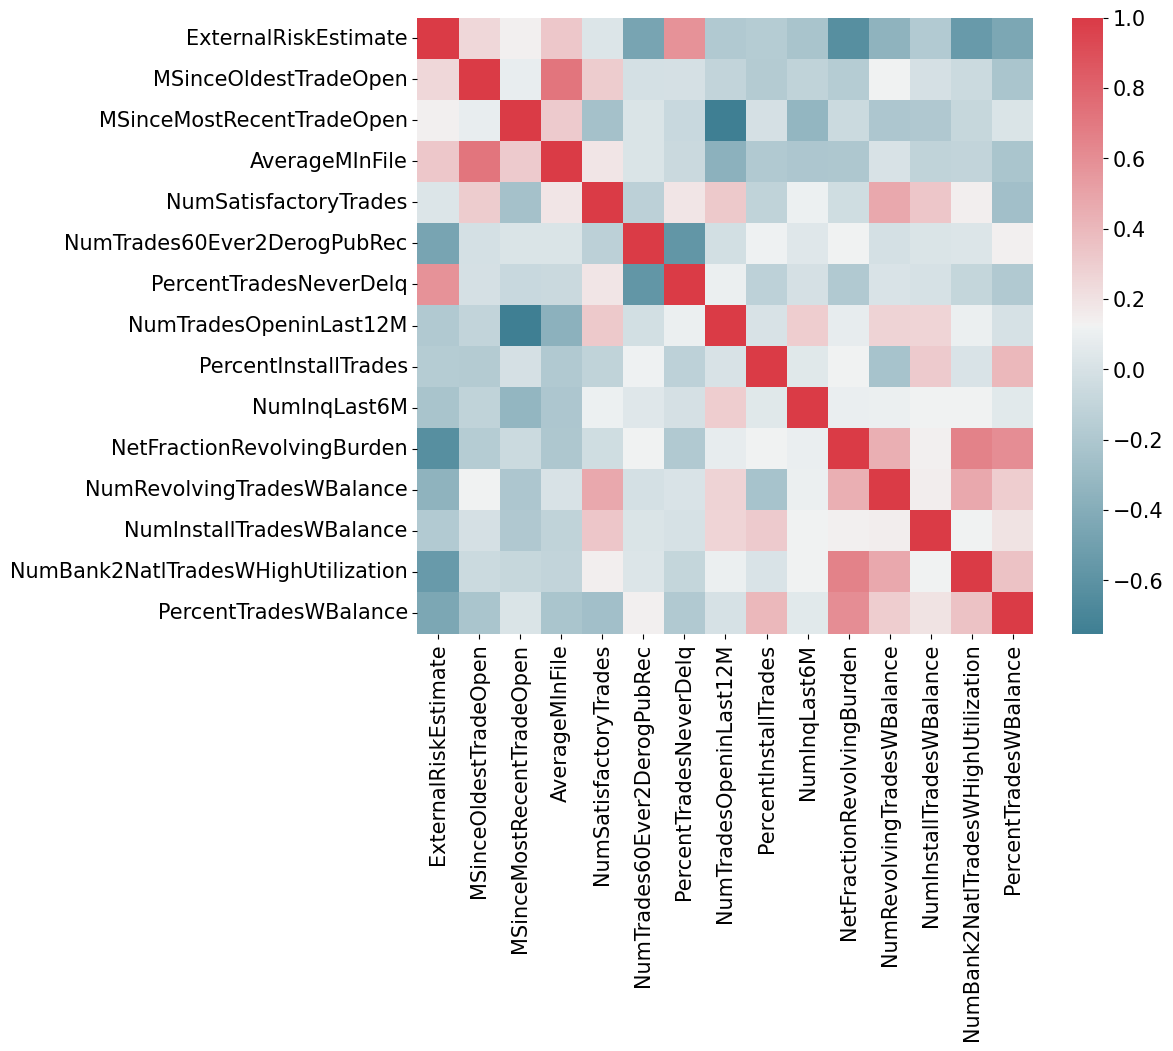

In [319]:
f, ax = plt.subplots(figsize=(10, 8))
corr = transformed.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

ok-ish

**Check other non-linear relationship**

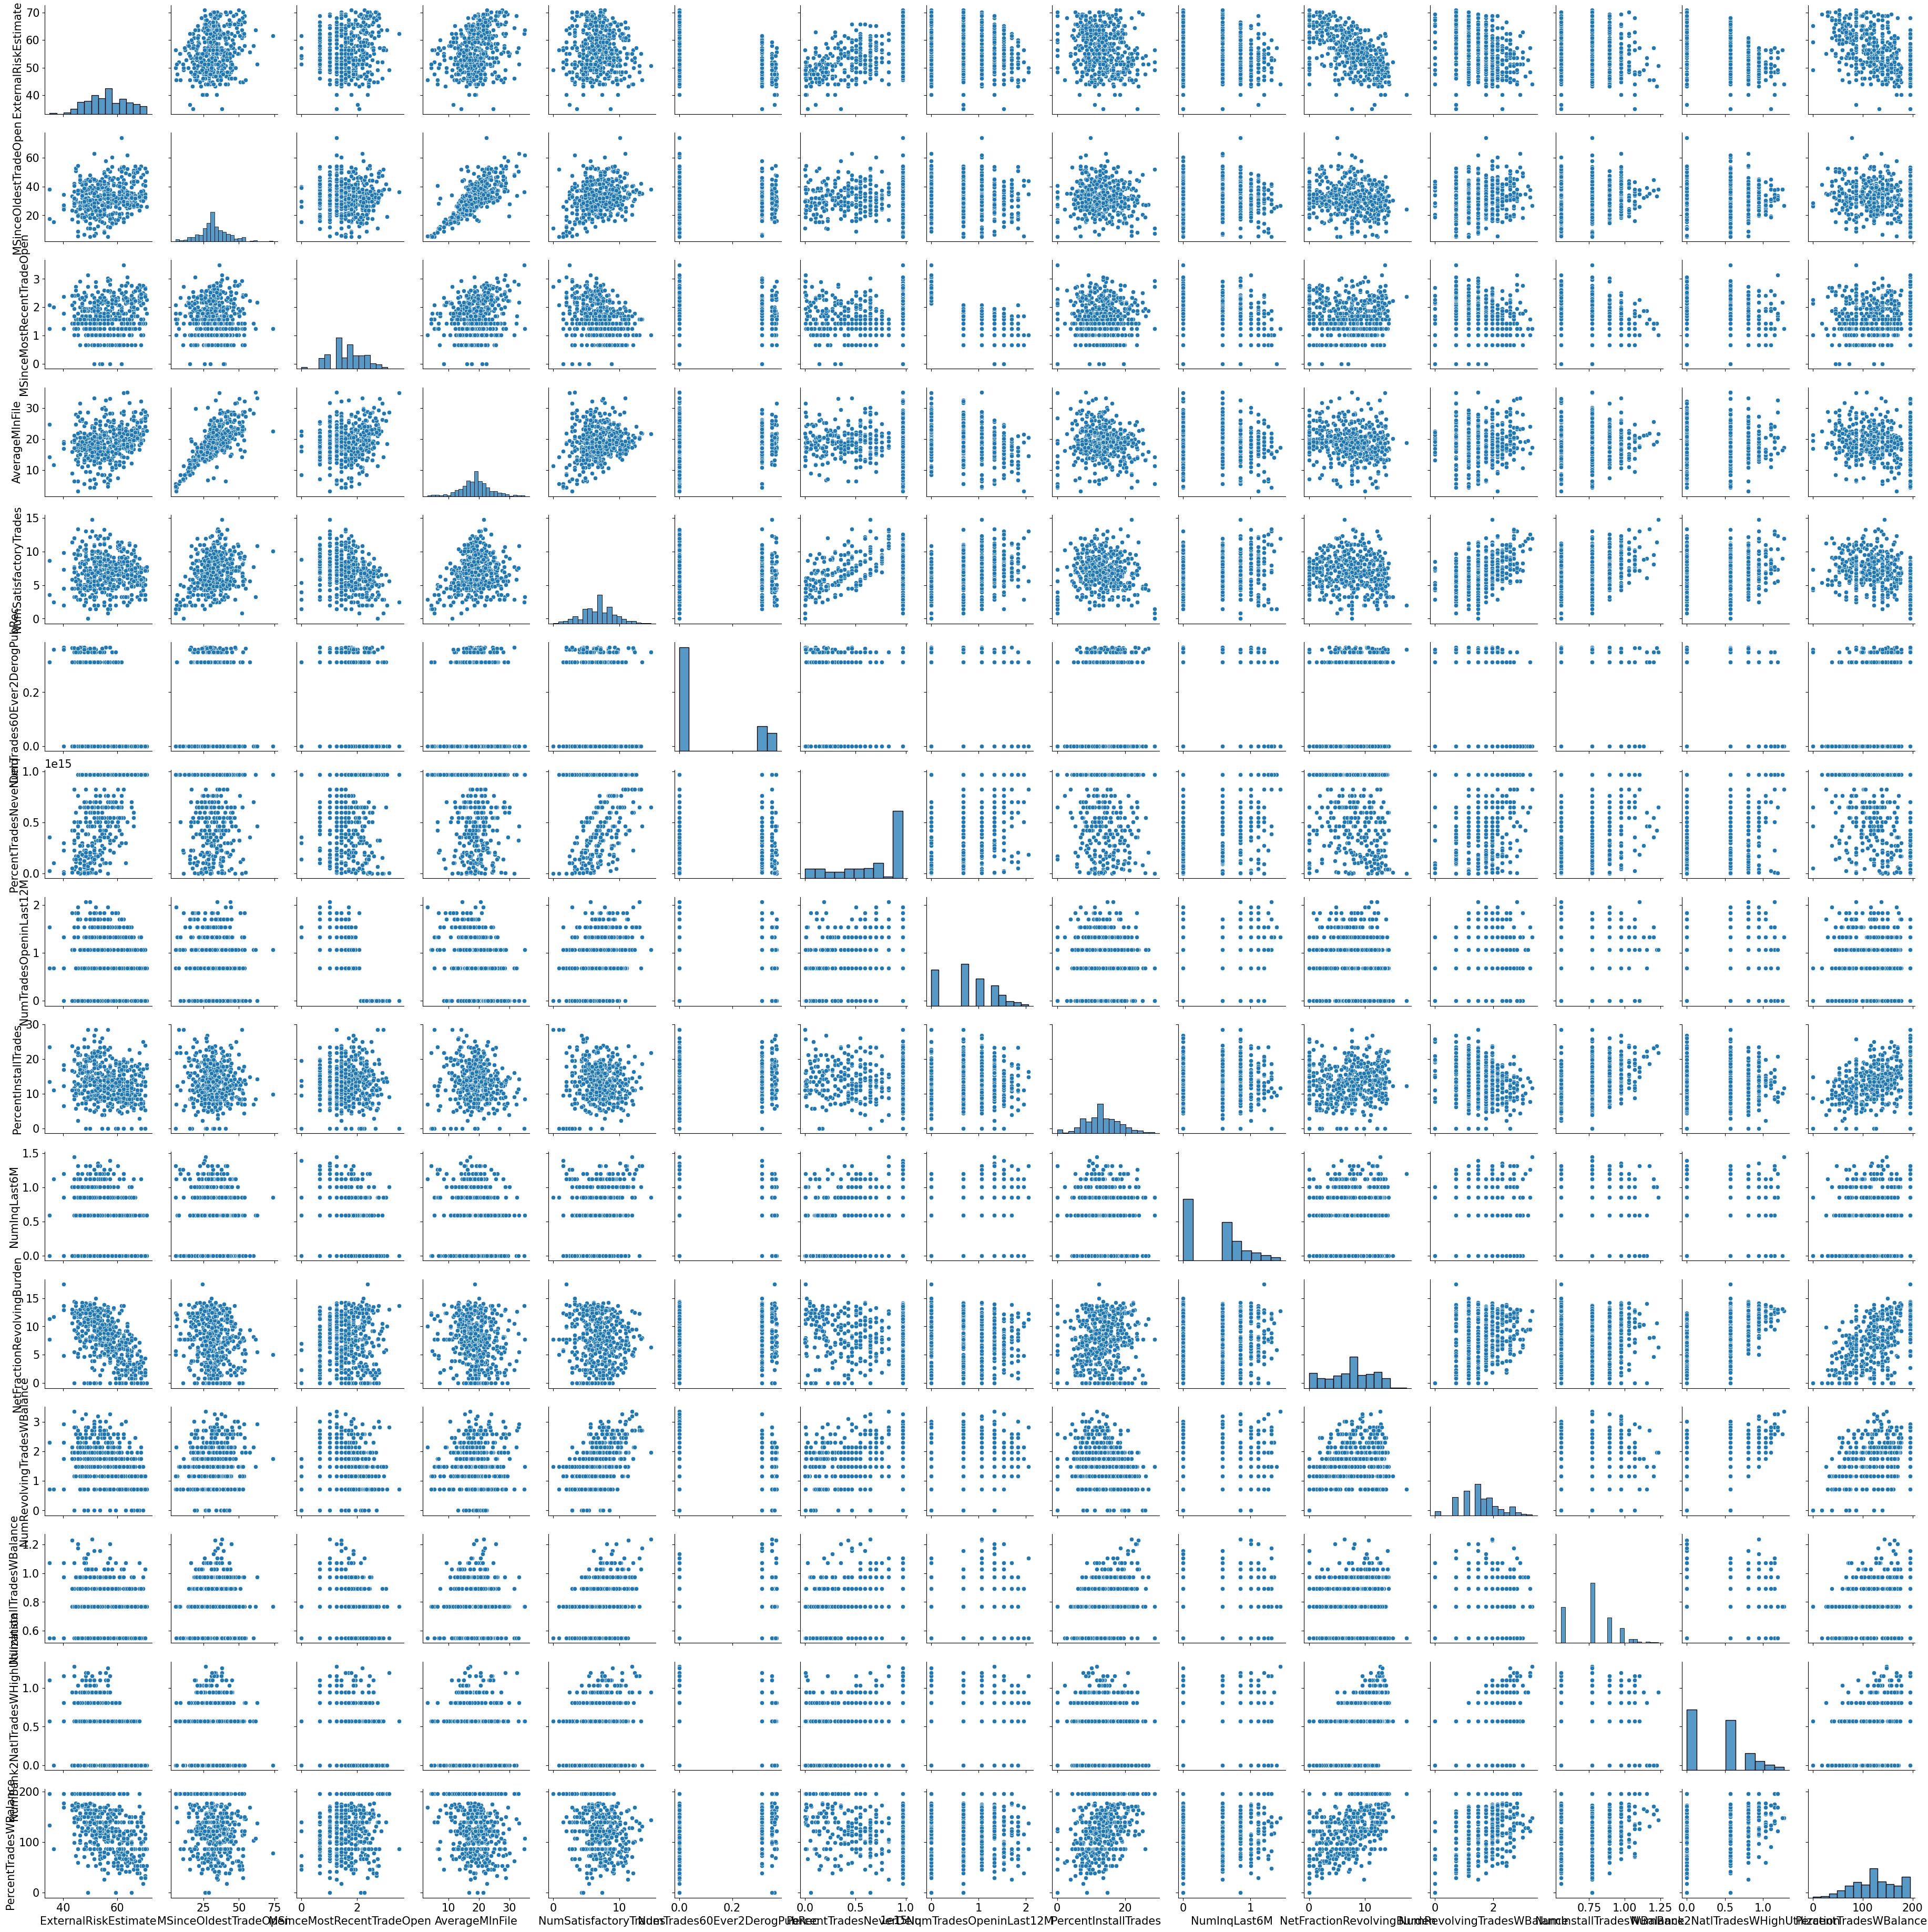

In [320]:
sample = transformed.sample(500, random_state=42)
sns.pairplot(sample)

Still alot of structure left

In [67]:
# final columns to drop
# first 3 because of missing values
# the rest because of multicorriliarity
drop_columns_heloc = ['MSinceMostRecentDelq',
                      'MSinceMostRecentInqexcl7days',
                      'NetFractionInstallBurden',
                      'NumTotalTrades',
                      'MaxDelq2PublicRecLast12M',
                      'MaxDelqEver',
                      'NumInqLast6Mexcl7days',
                      'NumTrades90Ever2DerogPubRec'
                      ]

### Prepare data sets

In [339]:
df_heloc = pd.read_csv("/content/drive/MyDrive/aml/data/heloc_train.csv")

In [96]:
def prepare_data_heloc_train(data, drop_columns):
  print("Inital dimensions:", data.values.shape)
  print("Recode labels")
  # replace labels with int values (because final submission needs to be 0, 1)
  data['RiskPerformance'] = data['RiskPerformance'].replace(('Bad','Good'), (0,1))
  print("Drop columns")
  data = data.drop(drop_columns, axis=1)
  print("New dimensions:", data.values.shape)
  print("Split in features and labels")
  # split to replace nas
  dfX = data.drop("RiskPerformance", axis=1)
  dfy = pd.DataFrame(data.loc[:, 'RiskPerformance'])
  print("Replace nas")
  dfX[dfX<0] = np.nan
  # get na rows index
  na_indexes = get_indexes_nan_rows(dfX)
  #drop na rows
  dfX = dfX.drop(na_indexes)
  dfy = dfy.drop(na_indexes)
  print("Impute nas")
  dfX = impute_heloc(dfX)
  return dfX.join(dfy)

In [97]:
heloc = prepare_data_heloc_train(df_heloc, drop_columns_heloc)

Inital dimensions: (9413, 24)
Recode labels
Drop columns
New dimensions: (9413, 16)
Split in features and labels
Replace nas
Impute nas


In [98]:
heloc

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,PercentTradesNeverDelq,NumTradesOpeninLast12M,PercentInstallTrades,NumInqLast6M,NetFractionRevolvingBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance
0,69.0,148.0,4.0,66.0,41.0,0.0,100.0,4.0,10.0,1.0,32.0,7.0,3.0,1.0,50.0,0
1,77.0,229.0,3.0,109.0,23.0,0.0,100.0,2.0,35.0,0.0,38.0,4.0,3.0,1.0,58.0,0
2,58.0,46.0,7.0,38.0,13.0,0.0,93.0,1.0,50.0,2.0,80.0,5.0,4.0,1.0,90.0,0
4,80.0,226.0,2.0,66.0,35.0,0.0,100.0,2.0,47.0,0.0,2.0,5.0,7.0,0.0,62.0,0
5,81.0,280.0,3.0,84.0,21.0,0.0,100.0,1.0,33.0,0.0,16.0,2.0,2.0,0.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9407,68.0,169.0,3.0,74.0,9.0,2.0,73.0,1.0,45.0,1.0,10.0,1.0,2.0,1.0,75.0,0
9408,65.0,115.0,11.0,43.0,19.0,0.0,90.0,1.0,50.0,0.0,52.0,5.0,6.0,0.0,85.0,0
9409,77.0,437.0,8.0,115.0,35.0,0.0,100.0,4.0,26.0,3.0,23.0,6.0,2.0,0.0,50.0,0
9410,75.0,140.0,7.0,56.0,21.0,0.0,100.0,1.0,27.0,1.0,20.0,3.0,2.0,1.0,56.0,1


In [100]:
def get_features_labels_heloc(data):
  X = data.drop("RiskPerformance", axis=1).values
  y = data.loc[:, 'RiskPerformance'].values
  return [X, y]

In [101]:
X, y = get_features_labels_heloc(heloc)


## Evaluate different classifiers

In [102]:
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Logistic Regression"
]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=10, random_state=42),
    RandomForestClassifier(
        max_depth=10, n_estimators=100, max_features=1, random_state=42
    ),
    AdaBoostClassifier(random_state=42),
    LogisticRegression(random_state=42)
]

def test_classifiers_heloc(x, y, names_classifiers, classifiers, transform=False):
  scores = []
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  if transform:
    X_train, X_test = transform_heloc([X_train, X_test])
  for name, clf in zip(names_classifiers, classifiers):
    print("Classifer" + name)
    results = {"model": name, "parameters": clf.get_params()}
    print("Train ")
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    print("Test")
    acc = clf.score(X_test, y_test)
    results.update({"score": acc})
    print("Done")
    scores.append(results)
  print(scores)
  return scores

In [104]:
test_classifiers_heloc(X, y, names, classifiers)

ClassiferNearest Neighbors
Train 
Test
Done
ClassiferDecision Tree
Train 
Test
Done
ClassiferRandom Forest
Train 
Test
Done
ClassiferAdaBoost
Train 
Test
Done
ClassiferLogistic Regression
Train 
Test
Done
[{'model': 'Nearest Neighbors', 'parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}, 'score': 0.678490990990991}, {'model': 'Decision Tree', 'parameters': {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}, 'score': 0.6762387387387387}, {'model': 'Random Forest', 'parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrea

[{'model': 'Nearest Neighbors',
  'parameters': {'algorithm': 'auto',
   'leaf_size': 30,
   'metric': 'minkowski',
   'metric_params': None,
   'n_jobs': None,
   'n_neighbors': 3,
   'p': 2,
   'weights': 'uniform'},
  'score': 0.678490990990991},
 {'model': 'Decision Tree',
  'parameters': {'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 10,
   'max_features': None,
   'max_leaf_nodes': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'min_weight_fraction_leaf': 0.0,
   'random_state': 42,
   'splitter': 'best'},
  'score': 0.6762387387387387},
 {'model': 'Random Forest',
  'parameters': {'bootstrap': True,
   'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 10,
   'max_features': 1,
   'max_leaf_nodes': None,
   'max_samples': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'min_weight_fraction_leaf': 0.0,
   'n_estimators

## Hyperparameter Tuning

In [348]:
def test_classifier_heloc(x, y, classifier):
  result = {"parameters": classifier.get_params()}
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  print("Train ")
  classifier = make_pipeline(StandardScaler(), classifier)
  classifier.fit(X_train, y_train)
  print("Test")
  acc = classifier.score(X_test, y_test)
  result.update({"score": acc})
  print("Done")
  print(result)
  return result

In [349]:
clf = RandomForestClassifier(
        max_depth=10, n_estimators=100, max_features=1, random_state=42
    )
test_classifier_heloc(X, y, clf)

Train 
Test
Done
{'parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'score': 0.6978226234731811}


{'parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': 1,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 100,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 'score': 0.6978226234731811}

# Make predictions

In [111]:
def prepare_data_heloc_test(data, drop_columns):
  print("Inital dimensions:", data.values.shape)
  print("Recode labels")
  print("Drop columns")
  data = data.drop(drop_columns, axis=1)
  print("New dimensions:", data.values.shape)
  print("Split in features and labels")
  print("Replace nas")
  data[data<0] = np.nan
  na_indexes = get_indexes_nan_rows(data)
  print("Impute nas")
  data = impute_heloc(data)
  return data, na_indexes

In [112]:
def make_prediction_heloc(train_set, drop_columns,  test_set, classifier, test_submission):
  train = prepare_data_heloc_train(train_set, drop_columns)
  test, na_indexes = prepare_data_heloc_test(test_set, drop_columns)
  X_test = test.values
  X,y = get_features_labels_heloc(train)
  print("train")
  classifier = make_pipeline(StandardScaler(), classifier)
  classifier.fit(X, y)
  print("predict")
  y_pred = classifier.predict(X_test)
  p = 5000/5459
  na_preds = np.random.binomial(1, p, size=len(na_indexes))
  y_pred[na_indexes] = na_preds
  test_submission['pred'] = y_pred.astype(int)
  test_submission = test_submission.drop('Prediction', axis=1)
  test_submission = test_submission.rename(columns={'pred': 'Prediction'})
  return test_submission

In [113]:
df_heloc = pd.read_csv("/content/drive/MyDrive/aml/data/heloc_train.csv")
drop_columns_heloc = ['MSinceMostRecentDelq',
                      'MSinceMostRecentInqexcl7days',
                      'NetFractionInstallBurden',
                      'NumTotalTrades',
                      'MaxDelq2PublicRecLast12M',
                      'MaxDelqEver',
                      'NumInqLast6Mexcl7days',
                      'NumTrades90Ever2DerogPubRec'
                      ]
heloc_test = pd.read_csv("/content/drive/MyDrive/aml/data/heloc_test.csv")
clf = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1, random_state=42)
submission_heloc = pd.read_csv("/content/drive/MyDrive/aml/data/heloc_test_submission.csv")


submission = make_prediction_heloc(df_heloc, drop_columns_heloc, heloc_test, clf, submission_heloc)

Inital dimensions: (9413, 24)
Recode labels
Drop columns
New dimensions: (9413, 16)
Split in features and labels
Replace nas
Impute nas
Inital dimensions: (1046, 23)
Recode labels
Drop columns
New dimensions: (1046, 15)
Split in features and labels
Replace nas
Impute nas
train
predict


In [116]:
submission.to_csv("/content/drive/MyDrive/aml/data/heloc_sub_1.csv", index=False)

In [259]:
# check rows, drop rows with more than 0.15 missing values
#def get_missing_values_per_row(df, delete=False, threshold=0.15, train=True):
#  data = df.copy()
#  if train:
#    data = data.drop('RiskPerformance', axis=1)
#    label = df.loc[:, 'RiskPerformance']
#  shape = data.values.shape
#  arr = data.values.flatten().reshape(shape)
#  arr[arr >= 0] = 0
#  arr[arr < 0] = 1
#  data['nans'] = arr.sum(axis=1).reshape((shape[0], 1))
#  data['percentage_nans'] = data['nans'].apply(lambda x: x/shape[1])
#  if delete:
#    indexes=data.index[data.loc[:, 'percentage_nans']>=threshold]
#    data = data.drop(indexes)
#    if train:
#      label = label.drop(indexes)
 #   data = data.drop(['nans', 'percentage_nans'], axis=1)
 #   if train:
 #     data = data.join(label)
 #   return data
 # else:
 #   if train:
 #     data = data.join(label)
 #   return data

In [253]:
#df_heloc = get_missing_values_per_row(df_heloc, delete=False)